#Initial dataloading and -creation

We downloaded the full COUGHVID dataset from https://zenodo.org/record/4048312 and uploaded it to a google drive. We then mounted this drive to the jupyter book and preprocessed it as shown below.

In [82]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [83]:
from scipy.io import wavfile
from scipy import signal
from scipy.io import wavfile
from scipy.signal import butter,filtfilt
from scipy.signal import cwt
from scipy.signal import hilbert
from scipy.signal import resample
from scipy.signal import decimate
from scipy.signal import spectrogram
from scipy.signal.windows import get_window
from scipy.stats import kurtosis
from scipy.integrate import simps

import librosa
import librosa.display
import matplotlib.pyplot as plt
import json
import os
import numpy as np
import skimage.io
import cv2
import tensorflow as tf
import csv
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import IPython.display as ipd
from shutil import copyfile, copy

from google.colab.patches import cv2_imshow

In [84]:
import warnings
warnings.filterwarnings("ignore")

# upgrade tables version to properly read h5 file
!pip install --upgrade tables

In [23]:
#### helper functions for sound file handling
def print_plot_play(x, Fs, text=''):
    """1. Prints information about an audio singal, 2. plots the waveform, and 3. Creates player
    
    Notebook: C1/B_PythonAudio.ipynb
    
    Args: 
        x: Input signal
        Fs: Sampling rate of x    
        text: Text to print
    """
    print('%s Fs = %d, x.shape = %s, x.dtype = %s' % (text, Fs, x.shape, x.dtype))
    plt.figure(figsize=(14, 5))
    plt.plot(x)
    plt.xlim([0, x.shape[0]])
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()
    ipd.display(ipd.Audio(data=x, rate=Fs))

With the library 'librosa', we can easily handle audio files and create data arrays and spectograms out of the cough samples:

 Fs = 22050, x.shape = (142884,), x.dtype = float32


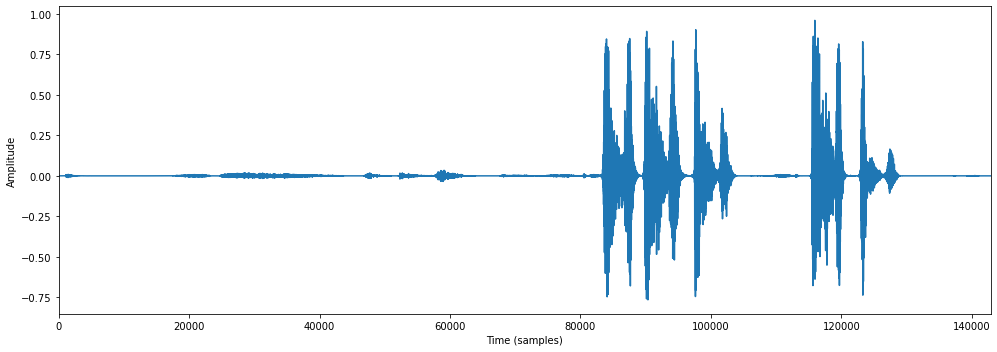

In [85]:
x_good , sr = librosa.load('./drive/MyDrive/COUGHVID/testcough_good.webm')
print_plot_play(x, sr)

Analyzing the dataset like this, we can observe that there are some coughs that don't really match quality requirements. For example the cough below:

 Fs = 22050, x.shape = (218295,), x.dtype = float32


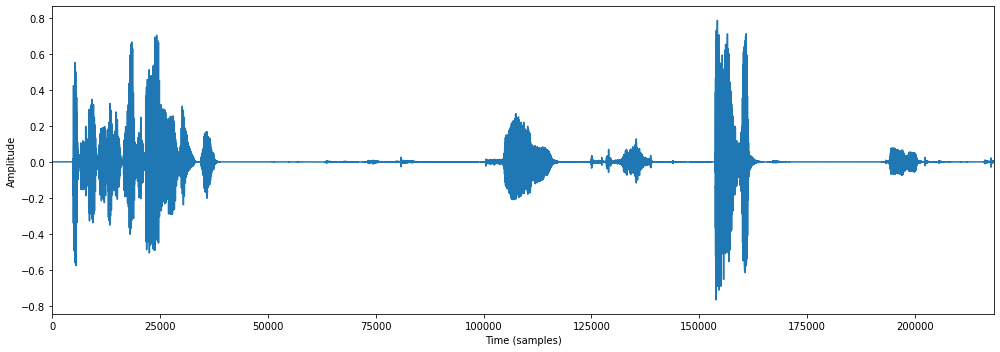

In [86]:
x_bad, sr = librosa.load('./drive/MyDrive/COUGHVID/testcough_bad.webm')
print_plot_play(x_bad, sr)

Furthermore, using librose, we can easily create and compare the cough samples and their respective MEL-spectogram that we will use as data later.

In [44]:
''' #plt.plot(x_good)
plt.figure(figsize=(14, 5))
M = librosa.feature.melspectrogram(y=x_good, sr=sr, n_mels=128)
M_db = librosa.power_to_db(M, ref=np.max) * -1
plt.figure(figsize=(14, 5))
librosa.display.specshow(M_db, ax=ax)
 '''

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

We create some helper functions to handle file extractions and spectogram image creation:

In [87]:

def load_json_from_drive(path,filename):
  with open(path + filename) as json_file:
    data = json.load(json_file)
  
  return data

def load_soundfile_from_drive(filename, path='./drive/MyDrive/COUGHVID/test_dset/'):
  x , sr = librosa.load(path + filename)
  return x, sr

def jsonFileNames(path='./drive/MyDrive/COUGHVID/test_dset/'):
    """
    Returns the names of all .json files in the path as list of strings
    """
    jsonFileNames = []
    for (dirpath, dirnames, filenames) in os.walk(path):
      for filename in filenames:
        if ".json" in filename:
          jsonFileNames.append(filename)
    return jsonFileNames

def audioFileNames(path='./drive/MyDrive/COUGHVID/test_dset/'):
  """
  Returns the name of all .webm and .ogg files in the path as list of string
  """
  audioFileNames = []
  for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
      if ".webm" in filename or ".ogg" in filename:
        audioFileNames.append(filename)
  
  return audioFileNames

def hasStatusAttribute(fileName, path='./drive/MyDrive/COUGHVID/test_dset/'):
    """
    Returns a boolean indicating if the specified json file has a 'status' key    
    """
    with open(path+fileName) as file:
        data = json.load(file)
        hasStatusAttribute = 'status' in data
        print('statusAttribute: ' + str(hasStatusAttribute))
        return hasStatusAttribute

def valueFromJsonParser(fileName, key, path='./drive/MyDrive/COUGHVID/test_dset/'):
    """
    Returns the status of the specified json file 
    """    
    with open(os.path.join(path, fileName)) as file:
        data = json.load(file)
        return data[str(key)]

def generateMelSpectrogram(fileName, inputPath='./drive/MyDrive/COUGHVID/test_dset/'):
    """
    Generates Mel Spectogram from cough sample.
    Note: multiply values by -1 to avoid black images during png conversion
    """
    x, sr = load_soundfile_from_drive(fileName, inputPath)
    M = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128)
    M_db = librosa.power_to_db(M, ref=np.max) * -1
    dim = (320,240) # resize to dimensions from https://www.sciencedirect.com/science/article/pii/S2352914820303026
    resized = cv2.resize(M_db, dim, interpolation=cv2.INTER_LINEAR)

    return resized

def coughDetectionIsAboveThreshold(fileName, threshold, path='./drive/MyDrive/COUGHVID/test_dset/'):
    coughDetectionIsAboveThreshold = False
    if float(valueFromJsonParser(fileName,'cough_detected',path)) > threshold:
        coughDetectionIsAboveThreshold = True
    return coughDetectionIsAboveThreshold

def generateAllMelSpectrogramsAndLabelsFile(outputPath, threshold, nData, inputPath='./drive/MyDrive/COUGHVID/test_dset/'):
    LabelsList = []
    ThresholdList = []
    filenames = jsonFileNamesTest()
    if nData > 0:
      filenames = filenames[0:nData - 1]
    for filename in filenames:
      filename = filename.strip()
      try:
        if hasStatusAttribute(filename,inputPath) and coughDetectionIsAboveThreshold(filename, threshold, inputPath):
          LabelsList.append(valueFromJsonParser(filename,'status',inputPath))
          ThresholdList.append(valueFromJsonParser(filename,'cough_detected',inputPath))
          audioFileName = filename.strip(".json")+".webm"
          if os.path.isfile(inputPath + audioFileName) == False:
            audioFileName = filename.strip(".json")+".ogg"
          melSpectrogram = generateMelSpectrogramTest(audioFileName,inputPath)
          melSpectrogramFileName = filename.strip(".json")+".png"
          melSpectrogramFilePath = os.path.join(outputPath,melSpectrogramFileName)
          cv2.imwrite(melSpectrogramFilePath, melSpectrogram)
      except FileNotFoundError:
        print('File was not found')
        continue
    with open(os.path.join(outputPath,"LabelsAndThresholds.csv"), 'w') as file:
      wr = csv.writer(file)
      wr.writerow(LabelsList)
      wr.writerow(ThresholdList)

    
def readAllMelSpecs(path='./drive/MyDrive/COUGHVID/large_test_dset/'):
  data = []
  for (dirpath, dirnames, filenames) in os.walk(path):
    for file in filenames:
      if '.png' in file:
        filepath = path + file
        tmp = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
        tmp_expanded=np.expand_dims(tmp,axis=1)
        data.append(tmp_expanded)

  return np.float32(np.array(data))

def oneHotEncoding(labels):
  oneHotList = []
  for label in labels:
    if label == 'healthy':
      oneHotList.append([1,0,0])
    elif label == 'symptomatic':
      oneHotList.append([0,0,1])
    elif label == 'COVID-19':
      oneHotList.append([0,1,0])

  return np.array(oneHotList)

def convertCSVToArrays(filepath = './drive/MyDrive/COUGHVID/test_dset/MelDiagrams/LabelsAndThresholds.csv'):

  labels = []
  coughValues = []

  with open(filepath, newline='') as csvfile:
      spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
      for index, row in enumerate(spamreader):
          entries = row[0].split(',')
          if index == 0:
            labels = entries
          else:
            coughValues = entries
  
  return np.array(labels), np.array(coughValues)

def parseToJsonFilename(filename):
  if ".webm" in filename:
    return filename.replace(".webm",".json")
  if ".ogg" in filename:
    return filename.replace(".ogg",".json")

We can't use any sound files that don't have a corresponding status attribute in their json file. Therefore we copy only those files that have a corresponding status attribute to another directory and call it the "clean" dataset. We will do all further work on this "clean" dataset.

In [ ]:
# cleans dataset by copying only files with status
# use with caution, takes a lot of time!!!


path = './drive/MyDrive/COUGHVID/public_dataset/'
destination = './drive/MyDrive/COUGHVID/public_dataset_cleaned/'

soundFileNames = []
for (dirpath, dirnames, filenames) in os.walk(path):
  for filename in filenames:
    if ".webm" in filename or ".ogg" in filename:
      soundFileNames.append(filename)



for fileName in soundFileNames:
  json_file_name = parseToJsonFilename(fileName)
  try:
    if hasStatusAttribute(path=path, fileName=json_file_name):
      copy(path + json_file_name, destination + json_file_name)
      copy(path + fileName, destination + fileName)
  except FileNotFoundError:
    print("file not found")
  


Furthermore, the COUGHVID dataset provides some functions to work upon the data. We use the predefined feature classes and the segment_cough function. See https://c4science.ch/diffusion/10770/ as source.

In [88]:
# TODO: extract to another file and import it as a function

def segment_cough(x,fs, cough_padding=0.2,min_cough_len=0.2, th_l_multiplier = 0.1, th_h_multiplier = 2):
    """Preprocess the data by segmenting each file into individual coughs using a hysteresis comparator on the signal power
    
    Inputs:
    *x (np.array): cough signal
    *fs (float): sampling frequency in Hz
    *cough_padding (float): number of seconds added to the beginning and end of each detected cough to make sure coughs are not cut short
    *min_cough_length (float): length of the minimum possible segment that can be considered a cough
    *th_l_multiplier (float): multiplier of the RMS energy used as a lower threshold of the hysteresis comparator
    *th_h_multiplier (float): multiplier of the RMS energy used as a high threshold of the hysteresis comparator
    
    Outputs:
    *coughSegments (np.array of np.arrays): a list of cough signal arrays corresponding to each cough
    cough_mask (np.array): an array of booleans that are True at the indices where a cough is in progress"""
                
    cough_mask = np.array([False]*len(x))
    

    #Define hysteresis thresholds
    rms = np.sqrt(np.mean(np.square(x)))
    seg_th_l = th_l_multiplier * rms
    seg_th_h =  th_h_multiplier*rms

    #Segment coughs
    coughSegments = []
    padding = round(fs*cough_padding)
    min_cough_samples = round(fs*min_cough_len)
    cough_start = 0
    cough_end = 0
    cough_in_progress = False
    tolerance = round(0.01*fs)
    below_th_counter = 0
    
    for i, sample in enumerate(x**2):
        if cough_in_progress:
            if sample<seg_th_l:
                below_th_counter += 1
                if below_th_counter > tolerance:
                    cough_end = i+padding if (i+padding < len(x)) else len(x)-1
                    cough_in_progress = False
                    if (cough_end+1-cough_start-2*padding>min_cough_samples):
                        coughSegments.append(x[cough_start:cough_end+1])
                        cough_mask[cough_start:cough_end+1] = True
            elif i == (len(x)-1):
                cough_end=i
                cough_in_progress = False
                if (cough_end+1-cough_start-2*padding>min_cough_samples):
                    coughSegments.append(x[cough_start:cough_end+1])
            else:
                below_th_counter = 0
        else:
            if sample>seg_th_h:
                cough_start = i-padding if (i-padding >=0) else 0
                cough_in_progress = True
    
    return coughSegments, cough_mask

def compute_SNR(x, fs):
    """Compute the Signal-to-Noise ratio of the audio signal x (np.array) with sampling frequency fs (float)"""
    segments, cough_mask = segment_cough(x,fs)
    RMS_signal = 0 if len(x[cough_mask])==0 else np.sqrt(np.mean(np.square(x[cough_mask])))
    RMS_noise = np.sqrt(np.mean(np.square(x[~cough_mask])))
    SNR = 0 if (RMS_signal==0 or np.isnan(RMS_noise)) else 20*np.log10(RMS_signal/RMS_noise)
    return SNR

In [89]:
# TODO: extract into extra file and import class
### feature classes from coughvid dataset
class features:
    # output should be  a np.array 
    # names should be a list of the size of output
    # add the number of features in output of each function
    n_std_dev = 1
    n_dummy = 2
    n_EEPD = 19
    n_PRE = 1
    n_ZCR = 1
    n_RMSP = 1
    n_DF = 1
    n_spectral_features = 6
    n_SF_SSTD = 2
    n_MFCC = 26
    n_CF = 1
    n_LGTH = 1
    n_SSL_SD = 2
    
    def __init__(self, FREQ_CUTS):
        self.FREQ_CUTS = FREQ_CUTS # list of Frequency Bands for the PSD
        self.n_PSD = len(FREQ_CUTS)
        
    def std_dev(self, data):
        # data: wav file of segment; fs, signal = wavfile.read(file)
        # output: value of the feature
        names = ['std_dev'] # list of output features  
        std_deviation = np.ones((1,1))*np.std(data[1])
        return std_deviation, names
    
    def dummy(self, data):
        # data: wav file of segment; fs, signal = wavfile.read(file)
        # output: value of the feature (MUST BE AN ARRAY)
        names = ['dummy_feature_2','dummy_3']
        return np.array([1.,2.]), names
    
    def fft(self,data):
        """
        Compute the spectrum using FFT
        """
        fs, cough = data
        fftdata = np.fft.rfft(cough)
        return fftdata
    
    # Envelope Energy Peak Detection
    def EEPD(self, data):
        # data: wav file of segment; fs, signal = wavfile.read(file)
        # output: value of the feature
        names = []
        fs,cough = data
        fNyq = fs/2
        nPeaks = []
        freq_step = 50
        for fcl in range(50,1000,freq_step):
            names = names + ['EEPD'+str(fcl)+'_'+str(fcl+freq_step)]
            fc = [fcl/fNyq, (fcl+50)/fNyq]
            b, a = butter(1, fc, btype='bandpass')
            bpFilt = filtfilt(b, a, cough)
            b,a = butter(2, 10/fNyq, btype='lowpass')
            eed = filtfilt(b, a, bpFilt**2)
            eed = eed/np.max(eed+1e-17)
            peaks,_ = signal.find_peaks(eed)
            nPeaks.append(peaks.shape[0])
        return np.array(nPeaks), names

    # Phase Power Ratio Estimation
    def PRE(self, data):
        # data: wav file of segment; fs, signal = wavfile.read(file)
        # output: value of the feature
        names = ['Power_Ratio_Est']
        fs,cough = data
        phaseLen = int(cough.shape[0]//3)
        P1 = cough[:phaseLen]
        P2 = cough[phaseLen:2*phaseLen]
        P3 = cough[2*phaseLen:]
        f = np.fft.fftfreq(phaseLen, 1/fs)
        P1 = np.abs(np.fft.fft(P1)[:phaseLen])
        P2 = np.abs(np.fft.fft(P2)[:phaseLen])
        P3 = np.abs(np.fft.fft(P3)[:phaseLen])
        P2norm = P2/(np.sum(P1)+1e-17)
        fBin = fs/(2*phaseLen +1e-17)
        f750,f1k,f2k5 = int(-(-750//fBin)), int(-(-1000//fBin)), int(-(-2500//fBin))
        ratio =  np.sum(P2norm[f1k:f2k5]) / np.sum(P2norm[:f750])
        return np.ones((1,1))*ratio, names
    
    # Zero Crossing Rate
    def ZCR(self, data):
        # data: wav file of segment; fs, signal = wavfile.read(file)
        # output: value of the feature
        names = ['Zero_Crossing_Rate']
        fs,cough = data
        ZCR = (np.sum(np.multiply(cough[0:-1],cough[1:])<0)/(len(cough)-1))
        return np.ones((1,1))*ZCR, names
    
    # RMS Power
    def RMSP(self, data):
        # data: wav file of segment; fs, signal = wavfile.read(file)
        # output: value of the feature
        names = ['RMS_Power']
        fs,cough = data
        RMS = np.sqrt(np.mean(np.square(cough)))
        return np.ones((1,1))*RMS, names
    
    # Dominant Frequency
    def DF(self, data):
        # data: wav file of segment; fs, signal = wavfile.read(file)
        # output: value of the feature
        names = ['Dominant_Freq']
        fs,cough = data
        cough_fortan = np.asfortranarray(cough)
        freqs, psd = signal.welch(cough_fortan)
        DF = freqs[np.argmax(psd)]
        return  np.ones((1,1))*DF, names
    
    def spectral_features(self, data):
        names = ["Spectral_Centroid","Spectral_Rolloff","Spectral_Spread","Spectral_Skewness","Spectral_Kurtosis","Spectral_Bandwidth"]
        fs, x = data
        magnitudes = np.abs(np.fft.rfft(x)) # magnitudes of positive frequencies
        length = len(x)
        freqs = np.abs(np.fft.fftfreq(length, 1.0/fs)[:length//2+1]) # positive frequencies
        sum_mag = np.sum(magnitudes)
        
        # spectral centroid = weighted mean of frequencies wrt FFT value at each frequency
        spec_centroid = np.sum(magnitudes*freqs) / sum_mag

        #spectral roloff = frequency below which 95% of signal energy lies
        cumsum_mag = np.cumsum(magnitudes)
        spec_rolloff = np.min(np.where(cumsum_mag >= 0.95*sum_mag)[0]) 

        #spectral spread = weighted standard deviation of frequencies wrt FFT value
        spec_spread = np.sqrt(np.sum(((freqs-spec_centroid)**2)*magnitudes) / sum_mag)

        #spectral skewness = distribution of the spectrum around its mean
        spec_skewness = np.sum(((freqs-spec_centroid)**3)*magnitudes) / ((spec_spread**3)*sum_mag)

        #spectral kurtosis = flatness of spectrum around its mean
        spec_kurtosis =  np.sum(((freqs-spec_centroid)**4)*magnitudes) / ((spec_spread**4)*sum_mag)

        #spectral bandwidth = weighted spectral standard deviation
        p=2
        spec_bandwidth = (np.sum(magnitudes*(freqs-spec_centroid)**p))**(1/p)

        return np.array([spec_centroid, spec_rolloff, spec_spread, spec_skewness, spec_kurtosis, spec_bandwidth]), names
    
    # Spectral Flatness and spectral standard deviation
    def SF_SSTD(self, data):
        # data: wav file of segment; fs, signal = wavfile.read(file)
        # output: value of the feature
        names = ['Spectral_Flatness', 'Spectral_StDev']
        fs,sig = data
        nperseg = min(900,len(sig))
        noverlap = min(600,int(nperseg/2))
        freqs, psd = signal.welch(sig, fs, nperseg=nperseg, noverlap=noverlap)
        psd_len = len(psd)
        gmean = np.exp((1/psd_len)*np.sum(np.log(psd + 1e-17)))
        amean = (1/psd_len)*np.sum(psd)
        SF = gmean/amean
        SSTD = np.std(psd)
        return np.array([SF, SSTD]), names
        
    #Spectral Slope and Spectral Decrease
    def SSL_SD(self,data):
        names=['Spectral_Slope','Spectral_Decrease']
        b1=0
        b2=8000
        
        Fs, x = data
        s = np.absolute(np.fft.fft(x))
        s = s[:s.shape[0]//2]
        muS = np.mean(s)
        f = np.linspace(0,Fs/2,s.shape[0])
        muF = np.mean(f)

        bidx = np.where(np.logical_and(b1 <= f, f <= b2))
        slope = np.sum(((f-muF)*(s-muS))[bidx]) / np.sum((f[bidx]-muF)**2)

        k = bidx[0][1:]
        sb1 = s[bidx[0][0]]
        decrease = np.sum((s[k]-sb1)/(f[k]-1+1e-17)) / (np.sum(s[k]) + 1e-17)

        return np.array([slope, decrease]), names
    
    #MFCC
    def MFCC(self,data):
        # data: wav file of segment; fs, signal = wavfile.read(file)
        # output: value of MFCC coefficient
        names = []; names_mean = []; names_std = []
        fs, cough = data
        n_mfcc = 13
        for i in range(n_mfcc):
            names_mean = names_mean + ['MFCC_mean'+str(i)]
            names_std = names_std +  ['MFCC_std'+str(i)]
        names = names_mean + names_std
        mfcc = librosa.feature.mfcc(y = cough, sr = fs, n_mfcc = n_mfcc)
        mfcc_mean = mfcc.mean(axis=1)
        mfcc_std = mfcc.std(axis=1)
        mfcc = np.append(mfcc_mean,mfcc_std)
        return mfcc, names
    
    # Crest Factor
    def CF(self,data):
        """
        Compute the crest factor of the signal
        """
        fs, cough = data
        peak = np.amax(np.absolute(cough))
        RMS = np.sqrt(np.mean(np.square(cough)))
        return np.ones((1,1))*peak/RMS, ['Crest_Factor']
    
    def LGTH(self,data):
        "Compute the length of the segment in seconds"
        fs, cough = data
        return np.ones((1,1))*(len(cough)/fs), ['Cough_Length']
    
    # Power spectral Density 
    def PSD(self,data):
        feat = []
        fs,sig = data
        nperseg = min(900,len(sig))
        noverlap=min(600,int(nperseg/2))
        freqs, psd = signal.welch(sig, fs, nperseg=nperseg, noverlap=noverlap)
        dx_freq = freqs[1]-freqs[0]
        total_power = simps(psd, dx=dx_freq)
        for lf, hf in self.FREQ_CUTS:
            idx_band = np.logical_and(freqs >= lf, freqs <= hf)
            band_power = simps(psd[idx_band], dx=dx_freq)
            feat.append(band_power/total_power)
        feat = np.array(feat)
        feat_names = [f'PSD_{lf}-{hf}' for lf, hf in self.FREQ_CUTS]
        return feat, feat_names

Working with the segment cough function, we can easily extract single coughs out of large samples as it is shown in the code below.

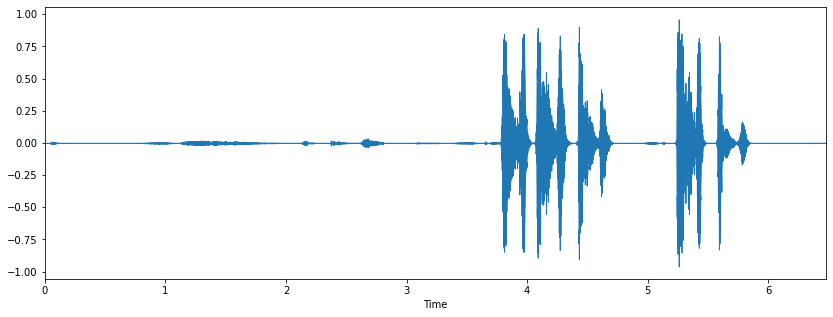

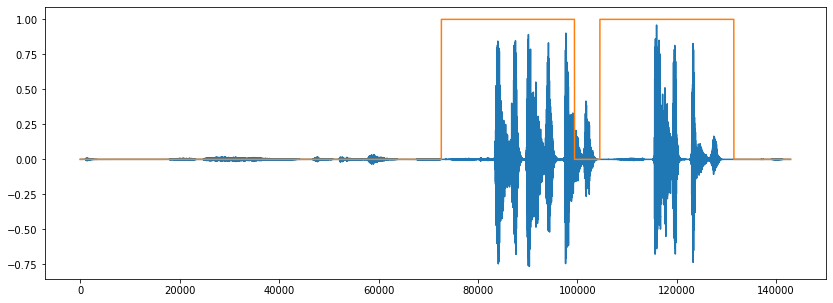

In [90]:
files = jsonFileNames()
x, sr = load_soundfile_from_drive(files[7].strip('.json') + '.webm')
plt.figure(figsize=(14,5))
librosa.display.waveplot(x)
x_new = librosa.stft(x)
x_db = librosa.amplitude_to_db(abs(x_new))

segments, cough_mask = segment_cough(x, sr, cough_padding=0.5)

plt.figure(figsize=(14,5))
#librosa.display.specshow(x_db, sr=sr)
plt.plot(x)
plt.plot(cough_mask)

We can than use this single coughs and pad them into a uniform length.

In [91]:
### helper functions for segmentation
def padSingleCough(single_sample, sampling_rate):
  padded = np.pad(single_sample, int((3*sr-single_sample.shape[0])/2))
  if padded.shape[0] == 66150:
   # print("dropping last element")
    padded = padded[:-1]
  if padded.shape[0] == 66148:
    #print("appending one element")
    padded = np.append(padded, 0)
  return padded

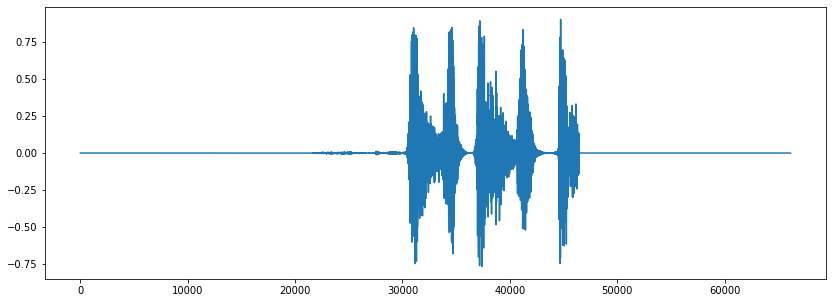

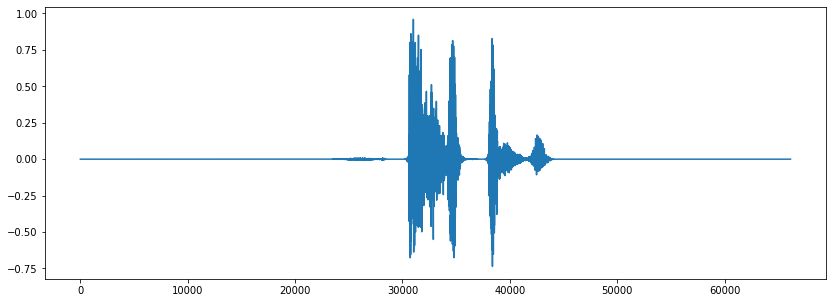

In [92]:

padded = padSingleCough(segments[0], sr)
padded_two = padSingleCough(segments[1], sr)

plt.figure(figsize=(14,5))
plt.plot(padded)

plt.figure(figsize=(14,5))
plt.plot(padded_two)

In [93]:
### Helper function to segment entire data
def createPaddedSamples(complete_sample, sampling_rate):
  padded_samples = np.array([]).reshape((0,66149))
  coughSegments, cough_mask = segment_cough(complete_sample, sampling_rate, cough_padding=0.4)
  amount = len(coughSegments)
  # drop sample if it is not segmentable
  if amount > 0:
    for segment in coughSegments:
      padded_sample = padSingleCough(segment, sampling_rate)
      padded_samples = np.vstack((padded_samples, padded_sample))

    return padded_samples, amount
  else:
    return None, None


def decomposeIntoSingleSamples(path):
  decomposed_samples = np.array([]).reshape((0,66149))
  labels = np.array([])
  cough_values = np.array([])
  filenames = audioFileNames(path)
  for filename in filenames:
    complete_sample, sampling_rate = load_soundfile_from_drive(filename, path)
    padded_samples, amount = createPaddedSamples(complete_sample, sampling_rate)
    if padded_samples is not None:
      decomposed_samples = np.vstack((decomposed_samples, padded_samples))
      jsonFileName = parseToJsonFilename(filename)
      label = valueFromJsonParser(fileName=jsonFileName, key = 'status', path=path)
      labels = np.hstack((labels, np.repeat(label,amount)))
      cough_value = valueFromJsonParser(fileName=jsonFileName, key='cough_detected',path=path)
      cough_values = np.hstack((cough_values, np.repeat(cough_value, amount)))

  return decomposed_samples, labels, cough_values


In [ ]:
# create entire data !!use with caution!!
data, labels, values = decomposeIntoSingleSamples('./drive/MyDrive/COUGHVID/public_dataset_cleaned/')

We can than use this data and the feature classes provided with the COUGHVID dataset to extract more features and put them into a single dataset file using pandas HDF5.

In [ ]:

# sampling rate is equal for all files
sampling_rates = np.copy(labels)
sampling_rates.fill('22050')

# create a feature class to calculate features
FREQ_CUTS = [(0,200),(300,425),(500,650),(950,1150),(1400,1800),(2300,2400),(2850,2950),(3800,3900)]
featCalc = features(FREQ_CUTS)

## calcuale spectral features
sr = 22050

spectral_centroid = []
spectral_roloff = []
spectral_spread = []
spectral_skewness = []
spectral_kurtosis = []
spectral_bandwidth = []
for row in data:
  res,_ = featCalc.spectral_features((sr,row))
  spectral_centroid.append(res[0])
  spectral_roloff.append(res[1])
  spectral_spread.append(res[2])
  spectral_skewness.append(res[3])
  spectral_kurtosis.append(res[4])
  spectral_bandwidth.append(res[5])

# compute cres factors
crest_factors = [featCalc.CF((sr,x))[0][0][0] for x in data]
# compute spectral slope and spectral decrease
spectral_slopes = [featCalc.SSL_SD((sr, x))[0][0] for x in data]
spectral_decreases = [featCalc.SSL_SD((sr, x))[0][1] for x in data]
# Spectral Flatness and spectral standard deviation
spectral_flatness = [featCalc.SF_SSTD((sr,x))[0][0] for x in data]
spectral_sstd = [featCalc.SF_SSTD((sr, x))[0][1] for x in data]
# Dominant Frequency
dom_freq = [featCalc.DF((sr, x))[0][0][0] for x in data]
# rms power
rms_pwrs = [featCalc.RMSP((sr, x))[0][0][0] for x in data]
# zero crossing rate
zero_crossing_rates = [featCalc.ZCR((sr, x))[0][0][0] for x in data]
# phase power ratio estimation
ppre = [featCalc.PRE((sr, x))[0][0][0] for x in data]
# power spectral densities
psd_0 = []
psd_300 = []
psd_500 = []
psd_950 = []
psd_1400 = []
psd_2300 = []
psd_2850 = []
psd_3800 = []

lists = [psd_0,psd_300,psd_500,psd_950,psd_1400,psd_2300,psd_2850,psd_3800]
for row in data:
  res = featCalc.PSD((sr, row))[0]
  for index, _ in enumerate(lists):
    lists[index].append(res[index])

In [ ]:
# create dictionary and pandas dataframe
sample_dict = {'sound':data.tolist(),'label':labels,'cough_value':values, 'sampling_rate': sampling_rates, 'spectral_centroid': spectral_centroid, 'spectral_bandwidth': spectral_bandwidth,
               'spectral_decreases': spectral_decreases, 'spectral_flatness': spectral_flatness, 'spectral_kurtosis':spectral_kurtosis, 'spectral_roloff':spectral_roloff,
               'spectral_skewness':spectral_skewness, 'spectral_slopes':spectral_slopes, 'spectral_spread':spectral_spread, 'spectral_sstd':spectral_sstd, 'dominant_frequency': dom_freq,
               'crest_factor': crest_factors, 'rms_power': rms_pwrs, 'zero_crossing_rate': zero_crossing_rates, 'phase_power_ratio_estimation': ppre,
               'pst_0':psd_0,'psd_300':psd_300,'psd_500':psd_500,'psd_950':psd_950,'psd_1400':psd_1400,'psd_2300':psd_2300,'psd_2850':psd_2850,'psd_3800':psd_3800}
df = pd.DataFrame(data=sample_dict)

We can now store this data frame into a file for simpler reloading.

In [ ]:
df.to_hdf('./drive/MyDrive/COUGHVID/dataset.h5',key="df",mode="w")

#Feature Extraction and Visualization

In this part, we try to extract meaningful feature combinations from the given data. First, we try to reproduce the feature engineering from https://www.sciencedirect.com/science/article/pii/S2352914820303026#fig1. In the second part, we analyze the dataset along our self-crafted features.

##Feature Extraction According to Paper

After simplyfing the data storage format, we can start to analyize it via clustering and principle component analysis. To ensure a better overview, we perform the clusterization on a smaller part of the whole dataset.

In [94]:
data = pd.HDFStore('./drive/MyDrive/COUGHVID/dataset_small.h5', mode='r')
data_df = data.get('/df')
X = data_df['sound'].to_numpy()
y = data_df['label'].to_numpy()

In [95]:
# Define some helper functions to load data for PCA and TSNE

def getFeaturesOfSample(mfcc, pca):
  means = np.mean(mfcc,axis=1)
  pcaProjections = pca.transform(mfcc.T)
  pcaMagnitudes = np.sum(np.abs(pcaProjections),axis=0)
  
  result = np.zeros((128,))
  for index, magnitude in enumerate(pcaMagnitudes):
    result += magnitude * pca.components_[index]
  
  return np.concatenate((means, result))

def generateTSNEData(data, pca):
  features = np.array(np.empty((256,)))
  for sample in data:
    mfcc = librosa.feature.mfcc(y=np.array(sample),sr=sr, n_mfcc=128)
    features_of_sample = getFeaturesOfSample(mfcc, pca)
    features = np.vstack((features, features_of_sample) )
    
  return features[1:]

def getTotalMFCCSData(data):
  mfccs_total = np.array(np.zeros((128,)))
  for sound in data:
    mfcc = librosa.feature.mfcc(y=np.array(sound), sr=sr, n_mfcc=128)
    mfccs_total = np.vstack((mfcc.T, mfccs_total))
  return mfccs_total

We start with the feature extraction and dataset analysis as it is presented in Subsection 2.2.3 of  https://www.sciencedirect.com/science/article/pii/S2352914820303026.

We perform PCA on the entire MFCC rows and append the top 10 PC Projections onto the original 128 MFCCs per sample. Thus we get a feature space of (256,1) per sample.

In [96]:
mfccs = getTotalMFCCSData(X)
print(mfccs.shape)

(140531, 128)


In [97]:
model = PCA(n_components=10)
model.fit(mfccs)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [98]:
features = generateTSNEData(X,model)
features.shape

(1081, 256)

In [99]:
X = features
y = y

tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(X)
print(tsne_result.shape)

(1081, 2)


Plotting of t-SNE results:

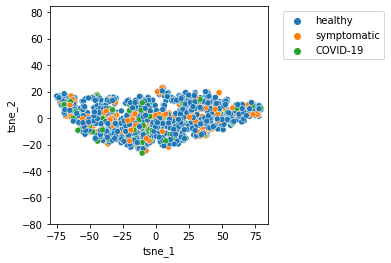

In [100]:
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)

The t-SNE results show that the classes do not form distinguishable clusters by the selected features.

Especially compared to the presented clusterization results in Fig. 1 of Section 2.2 of https://www.sciencedirect.com/science/article/pii/S2352914820303026#fig1, the COUGHVID dataset does not seem to be clusterizable by simply transfering the selected features.

Analyzation of the principle components show that only the first projection is a characteristic feature for a sample. The relative values of the projections decrease rapidly after the first projection, as the plot below shows. This indicates that it is quite hard to distinguish the classes on the selected features. Therefor, it is not surprising that the dataset does not form clusters on the projected featurespace.

In [101]:
print(model.explained_variance_ratio_)
print(model.singular_values_)
print(model.explained_variance_)

[0.91297571 0.02406483 0.01310615 0.00843991 0.00583869 0.00400896
 0.00309177 0.00240553 0.00205108 0.00188351]
[79062.60328699 12836.09385867  9472.81543154  7601.69352761
  6322.64869143  5239.10488359  4600.92439744  4058.32306413
  3747.42234176  3591.08491267]
[44480.85987701  1172.45645448   638.54146588   411.19863721
   284.4651425    195.31929112   150.63335452   117.19907559
    99.93008046    91.76610581]


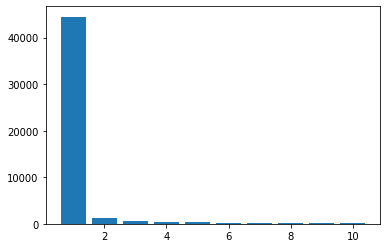

In [102]:
expl_var = model.explained_variance_
plt.bar(range(1,11), expl_var)
plt.show()

## t-SNE Clusterization on Handcrafted Features 

We try to cluster the dataset by using feature extraction functions that were released together with the COUGHVID dataset (see https://c4science.ch/diffusion/10770/). We perform a PCA on all of the handcrafted features. A list of the used features is shown below:


In [103]:
feature_names = data_df.columns[4:]
for feature_name in feature_names:
  print(feature_name)

spectral_centroid
spectral_bandwidth
spectral_decreases
spectral_flatness
spectral_kurtosis
spectral_roloff
spectral_skewness
spectral_slopes
spectral_spread
spectral_sstd
dominant_frequency
crest_factor
rms_power
zero_crossing_rate
phase_power_ratio_estimation
pst_0
psd_300
psd_500
psd_950
psd_1400
psd_2300
psd_2850
psd_3800


In [114]:
model_new = PCA(n_components=10)

In [115]:
various_data = data_df[feature_names]
features = model_new.fit_transform(various_data)

In [116]:
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(features)
print(tsne_result.shape)
labels = data_df['label']

(1081, 2)


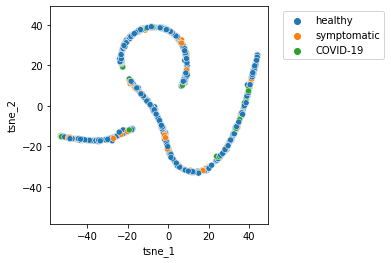

In [117]:
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': labels})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)

Analyziation of the PCA results:


In [119]:
print(model_new.explained_variance_ratio_)
print(model_new.singular_values_)
print(model_new.explained_variance_)

[9.99954646e-01 4.42813425e-05 9.85949277e-07 8.68222969e-08
 6.44317153e-11 2.73983757e-11 5.81299069e-13 1.41762347e-13
 1.22614061e-13 6.16716863e-14]
[1.39261979e+07 9.26729103e+04 1.38283288e+04 4.10353411e+03
 1.11787246e+02 7.28961884e+01 1.06179879e+01 5.24351916e+00
 4.87654854e+00 3.45848044e+00]
[1.79573138e+11 7.95210028e+06 1.77058036e+05 1.55916594e+04
 1.15707301e+01 4.92023544e+00 1.04390432e-01 2.54578640e-02
 2.20191904e-02 1.10750805e-02]


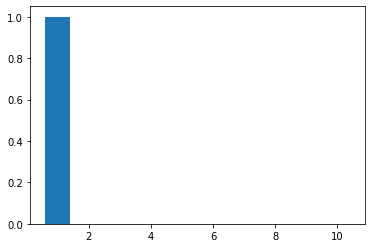

In [123]:
expl_var = model_new.explained_variance_ratio_
plt.bar(range(1,11), expl_var)
plt.show()

The variances of the principle components show that the dataset is mainly a one dimensional subspace. However, the given features do not form proper clusters w.r.t. the given classes. This also explains the t-SNE result shown in the second plot.

We store the total mfccs array in anothter dataframe for late reuse.

In [125]:
mfccs_dict = {'mfcc':mfccs.tolist()}
mfccs_df = pd.DataFrame(data=mfccs_dict)

In [128]:
mfccs_df.to_hdf('./drive/MyDrive/COUGHVID/mfccs_total_small.h5','mfccs_total')